# Извлечение и обработка "грязных" данных

## Постановка задачи

### Структура данных

- данные записываются для каждого пользователя, совершившего покупки, каждый день
- для каждой даты есть своя папка, внутри неё – папки для каждого пользователя
- внутри каждой папки есть файл `data.csv`, где и хранятся данные

### Задачи

1. Собрать все данные из папки `data` в один датафрэйм, имеющий следующие столбцы: колонки из самих файлов (`product_id`, `quantity`), а также имя пользователя (`name`), и дата этих покупок (`date`), соответствует названию папки, где лежит папка с пользователем)

2. Выяснить, какой пользователь купил больше всего товаров. Если их несколько, то перечислить имена через запятую с пробелом и в алфавитном порядке.

3. Найти топ-10 товаров по числу проданных единиц за всё время.

4. Визуализировать продажи по дням.

5. Сколько пользователей приобрели какой-либо товар повторно (более 1 раза)? Повтором будем считать покупку товара с одинаковым `product_id`, совершенную в разные дни. 

## Импорт библиотек

In [2]:
import pandas as pd
import os
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Решение поставленных задач
### 1. Сбор данных из файлов в одну таблицу

Данные из папки `data` должны быть объединены в одну таблицу со столбцами:
- колонки из самих файлов (`product_id`, `quantity`), 
- имя пользователя (`name`), 
- дата этих покупок (`date`), соответствует названию папки, где лежит папка с пользователем

Получаем список папок и файлов, в которых расположены данные:

In [3]:
data_path = './data/'
folder_data = os.listdir(data_path)

In [4]:
folder_data

['2020-12-03',
 '2020-12-04',
 '2020-12-05',
 '2020-12-06',
 '2020-12-07',
 '2020-12-08',
 '2020-12-09']

In [5]:
folders = []
for path, dirs, files in os.walk(data_path) :
    if dirs :
        folders.append(dirs)

In [6]:
dates = folders[0] # Список дат
days_q = len(dates) # Количество дней
all_names = folders[1:] # Список списков имён

Подсчёт общего количества путей к файлам (и самих файлов), которые надо будет обработать

In [7]:
s = 0
for i in range(len(all_names)) :
    s = s + len(all_names[i])
s

44

In [8]:
listof_df = []
idx = 0
# i - индекс в списке имён папок, названных по датам (level 1)
for i in range(0, days_q) : 
    date = dates[i]
    users = all_names[i]
    # user - имя одной из папок, названной по имени пользователя, купившего товар в данную дату
    # print(date, ':', users)
    for user in users : 
        filename = data_path + date + '/' + user + '/data.csv'
        tmp_df = pd.read_csv(filename, index_col = 0)
        nrows = tmp_df.shape[0]
        tmp_df['name'] = user
        tmp_df['date'] = date
        #print(tmp_df)
        idx = idx + 1
        listof_df.append(tmp_df)
print("Total files read:", idx)

Total files read: 44


In [9]:
df = pd.concat(listof_df, ignore_index = 1).sort_values(['date', 'name'])

In [10]:
df.head()

,product_id,quantity,name,date
0,47,1,Alexey_Smirnov,2020-12-03
1,57,1,Alexey_Smirnov,2020-12-03
2,14,2,Alexey_Smirnov,2020-12-03
3,52,1,Alexey_Smirnov,2020-12-03
4,1,4,Alexey_Smirnov,2020-12-03


Общее количество купленных товаров:

In [11]:
df.quantity.sum()

480

### 2. Кто купил больше всего товаров

Определим пользователей, купивших больше всего товаров. Если их несколько, то перечислим имена через запятую с пробелом и в алфавитном порядке.

In [12]:
best_buyer = df \
    .groupby('name') \
    .agg({'quantity': 'sum'}) \
    .sort_values('quantity', ascending = False)

In [13]:
best_buyer.quantity.max()

52

In [14]:
best_buyer[best_buyer['quantity'] == best_buyer.quantity.max()] \
    .reset_index() \
    .name \
    .sort_values() \
    .to_list()

['Alexey_Smirnov', 'Petr_Smirnov']

### 3. Топ-10 проданных товаров

Найдём топ-10 товаров по числу проданных единиц за всё время.

In [15]:
bestsellers = \
    df \
    .groupby('product_id', as_index = False) \
    .agg({'quantity': 'sum'})\
    .sort_values(by = 'quantity', ascending = False) \
    .reset_index(drop = True) 

In [16]:
bestsellers.head()

,product_id,quantity
0,27,20
1,56,18
2,24,15
3,74,15
4,41,14


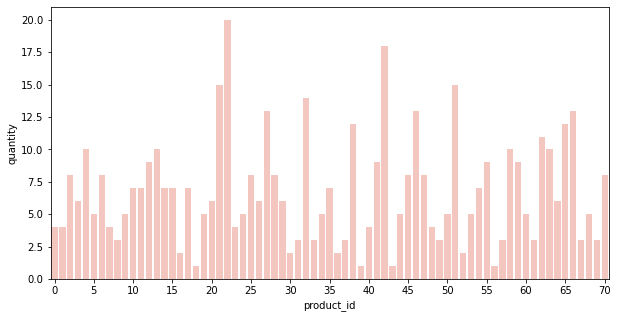

In [17]:
plt.figure(figsize=(10,5))
sns.barplot(x = 'product_id', y = 'quantity', data = bestsellers,
                 color = "salmon", alpha = .5)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5))

### 4. Повторные покупки

Подсчитаем пользователей, приобретших какой-либо товар повторно (более 1 раза)? Повтором считается покупка товара с одинаковым `product_id`, совершенная в разные дни.

In [18]:
names = df['name'] \
    .drop_duplicates() \
    .reset_index(drop = True)

In [19]:
users_with_repeated_purchases = []
all_duplicates = []
for user in names :
    user_purchases = \
        df[df.name == user] \
        [['product_id', 'date']] \
        .reset_index(drop = True) \
        .sort_values(by = ['product_id']) \
        .reset_index(drop = True)
    
    has_duplicates = \
        user_purchases \
        .duplicated(subset = ['product_id'])

    if (has_duplicates.sum() > 0) :
        new_index = has_duplicates.shape[0]
        
        indexes = has_duplicates[has_duplicates].index.values
        products = [user_purchases.iloc[i]['product_id'] for i in indexes]
        tmp_df = user_purchases.query("product_id in @products")
        tmp_df = tmp_df \
            .groupby(['product_id', 'date'], as_index = [False, False]) \
            .agg({'date': 'count'}) \
            .rename(columns = {'date': 'purchases'}) \
            .reset_index()
        
        for p in products :
            if tmp_df.query("product_id == @p").shape[0] > 1 :
                users_with_repeated_purchases.append(user)
                print(user)
                print(tmp_df)

Petr_Fedorov
   product_id        date  purchases
0          94  2020-12-03          1
1          94  2020-12-07          1
Anton_Ivanov
   product_id        date  purchases
0          15  2020-12-07          1
1          15  2020-12-09          1


In [20]:
users_with_repeated_purchases

['Petr_Fedorov', 'Anton_Ivanov']